In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import colors
from matplotlib.colors import ListedColormap
from natsort import natsorted
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from tifffile import imread
from umap import UMAP
import hdbscan
from joblib import Memory
from skimage.util.dtype import img_as_float
from skimage.color import gray2rgb

In [2]:
core = '12'
channels = [f'DNA1:{core}']

In [3]:
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [4]:
def categorical_cmap(numUniqueSamples, numCatagories, cmap='tab10', continuous=False):

    numSubcatagories = math.ceil(numUniqueSamples/numCatagories)

    if numCatagories > plt.get_cmap(cmap).N:
        raise ValueError('Too many categories for colormap.')
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0, 1, numCatagories))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(numCatagories, dtype=int))
        # rearrange hue order to taste
        cd = {
            'B': 0, 'O': 1, 'G': 2, 'R': 3, 'Pu': 4,
            'Br': 5, 'Pi': 6, 'Gr': 7, 'Y': 8, 'Cy': 9,
            }
        myorder = [
            cd['B'], cd['O'], cd['G'], cd['Pu'], cd['Y'],
            cd['R'], cd['Cy'], cd['Br'], cd['Gr'], cd['Pi']
            ]
        ccolors = [ccolors[i] for i in myorder]

        # use Okabe and Ito color-safe palette for first 6 colors
        # ccolors[0] = np.array([0.91, 0.29, 0.235]) #E84A3C
        # ccolors[1] = np.array([0.18, 0.16, 0.15]) #2E2926
        ccolors[0] = np.array([0.0, 0.447, 0.698, 1.0])  # blue
        ccolors[1] = np.array([0.902, 0.624, 0.0, 1.0])  # orange
        ccolors[2] = np.array([0.0, 0.620, 0.451, 1.0])  # bluish green
        ccolors[3] = np.array([0.8, 0.475, 0.655, 1.0])  # reddish purple
        ccolors[4] = np.array([0.941, 0.894, 0.259, 1.0])  # yellow
        ccolors[5] = np.array([0.835, 0.369, 0.0, 1.0])  # vermillion

    cols = np.zeros((numCatagories * numSubcatagories, 3))
    for i, c in enumerate(ccolors):
        chsv = colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv, numSubcatagories).reshape(numSubcatagories, 3)
        arhsv[:, 1] = np.linspace(chsv[1], 0.25, numSubcatagories)
        arhsv[:, 2] = np.linspace(chsv[2], 1, numSubcatagories)
        rgb = colors.hsv_to_rgb(arhsv)
        cols[i * numSubcatagories:(i + 1) * numSubcatagories, :] = rgb
    cmap = colors.ListedColormap(cols)

    # trim colors if necessary
    if len(cmap.colors) > numUniqueSamples:
        trim = len(cmap.colors) - numUniqueSamples
        cmap_colors = cmap.colors[:-trim]
        cmap = colors.ListedColormap(cmap_colors, name='from_list', N=None)

    return cmap

In [5]:
# out dir
out_dir = '../output/Fig4h'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# read raw single-cell data
data = pd.read_csv(f'../input/Dataset3(TMA)/csv/unmicst-{core}_cellMask.csv')

In [6]:
# crop
ymin = 1775
ymax = 1925
xmin = 1250
xmax = 1400

# read DNA1 image of selected tissue and crop
dna = imread(f'../input/Dataset3(TMA)/tif/{core}.ome.tif', key=0)
dna_crop = dna[ymin:ymax, xmin:xmax]

# read immunomarker channel of selected tissue and crop
ch = imread(f'../input/Dataset3(TMA)/tif/{core}.ome.tif', key=5)
ch_crop = ch[ymin:ymax, xmin:xmax]

# read segmentation outlines of selected tissue and crop
seg = imread(f'../input/Dataset3(TMA)/seg/{core}.ome.tif', key=0)
seg_crop = seg[ymin:ymax, xmin:xmax]

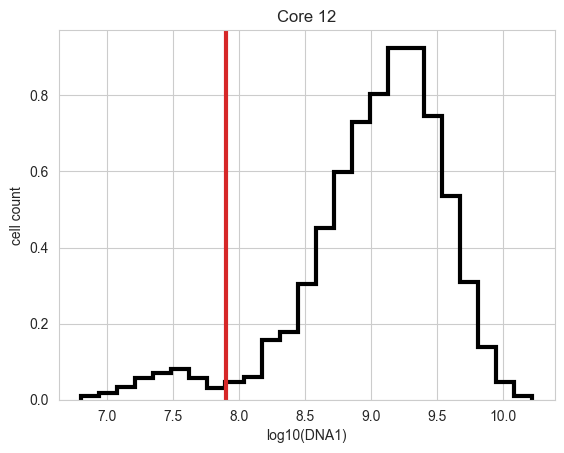

In [7]:
# isolate data for cells within ROI bounds
data_crop = data[['Y_centroid', 'X_centroid', 'DNA1']][
    (data['X_centroid'].between(xmin, xmax, inclusive='both')) &
    (data['Y_centroid'].between(ymin, ymax, inclusive='both'))
    ]

gate = (0.0, 7.9)

# color cells according to nuclear brightness
dim_ids = data['CellID'][
    np.log(data['DNA1']).between(gate[0], gate[1], inclusive='both')
    ]
data['color'] = [
    'red' if i in list(dim_ids) else
    'gainsboro' for i in data['CellID']
    ]

data_gated = data[['Y_centroid', 'X_centroid', 'DNA1']][
    (np.log(data['DNA1']).between(gate[0], gate[1], inclusive='both'))
    ]

sns.set_style('whitegrid')
plt.hist(np.log(data['DNA1']), bins=25, color='k', density=True, histtype='step', lw=3.0)
plt.axvline(gate[1], c='tab:red', lw=3.0)
plt.title(f'Core {core}')
plt.xlabel('log10(DNA1)')
plt.ylabel('cell count')
plt.savefig(os.path.join(out_dir, 'gated_hist.pdf'))
plt.show()
plt.close('all')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


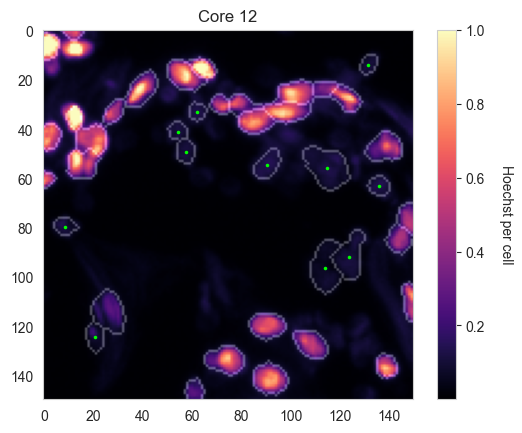

In [8]:
blank = np.zeros((dna_crop.shape[0], dna_crop.shape[1]))
blank = gray2rgb(blank)

dna_crop = img_as_float(dna_crop)
dna_crop = np.clip(dna_crop, 0, 0.3)
dna_crop = (dna_crop - np.min(dna_crop))/np.ptp(dna_crop)

dna_crop_rgb = plt.cm.magma(dna_crop) # converts to RGBA automatically
dna_crop_rgb = dna_crop_rgb[:, :, 0:3]  # drop alpha dimension
blank += dna_crop_rgb

seg_crop = img_as_float(seg_crop)
seg_crop_rgb = gray2rgb(seg_crop)
seg_crop_rgb *= 0.5
blank += seg_crop_rgb

# plot cropped image channels, segmentation outlines, and analysis rectangle
plt.imshow(blank, cmap='magma')
plt.grid(False)
cbar = plt.colorbar()
# cbar = plt.colorbar(format=ticker.FuncFormatter(fmt))
cbar.set_alpha(1.0)
cbar.set_label('Hoechst per cell', labelpad=20, rotation=270)
cbar.draw_all()

# transform x, y coordinates of cells within ROI bounds
data_gated['X_centroid'] = data_crop['X_centroid']-xmin
data_gated['Y_centroid'] = data_crop['Y_centroid']-ymin

# overlay cell centroids
plt.scatter(
    data_gated['X_centroid'],
    data_gated['Y_centroid'],
    s=6.5, lw=0.0, color='lime'
    )
plt.title(f'Core {core}')
plt.savefig(os.path.join(out_dir, 'dim_nuclei.png'), dpi=1000)

# save as a pdf, too
plt.savefig(os.path.join(out_dir, 'dim_nuclei.pdf'))
plt.show()
plt.close('all')